In this notebook we are going to:
* Identify the pointing spectra for our observation
* Load and plot the spectra
* Correct the bandpass by subtracting frequency-switched pointing pairs
* Flatten the residual baseline using a third order polynomial fit
* Find the measured amplitude of the strongest maser peak at each position
* Calculate a pointing correction assuming a Gaussian beam

In [33]:
%matplotlib inline
from astropy.io import fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.time import Time

**Find the data**

In [34]:
work_dir = '/Users/sharmila/AVN/Ghana_training/data/G0096_67/2006d175'
os.chdir(work_dir)

In [35]:
ls *.fits

2006d175_21h14m12s_Spec_sharmila_G9.62+0.20.fits  2006d175_21h19m27s_Spec_sharmila_G9.62+0.20.fits
2006d175_21h15m22s_Spec_sharmila_G9.62+0.20.fits  2006d175_21h20m22s_Spec_sharmila_G9.62+0.20.fits
2006d175_21h16m32s_Spec_sharmila_G9.62+0.20.fits  2006d175_21h28m52s_Spec_sharmila_G9.62+0.20.fits
2006d175_21h18m17s_Spec_sharmila_G9.62+0.20.fits  2006d175_21h36m57s_Spec_sharmila_G9.62+0.20.fits


For Hart spectral line data, each integration is stored as a separate FITS file.  This particular sequence of observations consists of short pointing checks to the half-power cardinal points and the centre position, and a pair of frequency-switched full-length scans on the central position. Data is recorded in dual polarisation: LCP and RCP.

2006d175_21h14m12s_Spec_sharmila_G9.62+0.20.fits HPN Pointing

2006d175_21h15m22s_Spec_sharmila_G9.62+0.20.fits HPS Pointing

2006d175_21h16m32s_Spec_sharmila_G9.62+0.20.fits HPE Pointing

2006d175_21h18m17s_Spec_sharmila_G9.62+0.20.fits HPW Pointing

2006d175_21h19m27s_Spec_sharmila_G9.62+0.20.fits ON Pointing

2006d175_21h20m22s_Spec_sharmila_G9.62+0.20.fits ON Pointing

2006d175_21h28m52s_Spec_sharmila_G9.62+0.20.fits 

2006d175_21h36m57s_Spec_sharmila_G9.62+0.20.fits

In [36]:
file_list = np.loadtxt(fname='list', delimiter=' ', 
                       dtype={'names' : ('filename', 'position', 'pointing'),
                             'formats' : ('S100', 'S3', 'b')})
file_list



array([('2006d175_21h14m12s_Spec_sharmila_G9.62+0.20.csv', 'HPN', 1),
       ('2006d175_21h15m22s_Spec_sharmila_G9.62+0.20.csv', 'HPS', 1),
       ('2006d175_21h16m32s_Spec_sharmila_G9.62+0.20.csv', 'HPE', 1),
       ('2006d175_21h18m17s_Spec_sharmila_G9.62+0.20.csv', 'HPW', 1),
       ('2006d175_21h19m27s_Spec_sharmila_G9.62+0.20.csv', 'ON', 1),
       ('2006d175_21h20m22s_Spec_sharmila_G9.62+0.20.csv', 'ON', 1),
       ('2006d175_21h28m52s_Spec_sharmila_G9.62+0.20.csv', 'ON', 0),
       ('2006d175_21h36m57s_Spec_sharmila_G9.62+0.20.csv', 'ON', 0)], 
      dtype=[('filename', 'S100'), ('position', 'S3'), ('pointing', 'i1')])

In [37]:
#replace 'csv' extension with 'fits'
for i, filename in enumerate(file_list['filename']):
    file_list['filename'][i] = filename[0:-3] + 'fits'
    
file_list

array([('2006d175_21h14m12s_Spec_sharmila_G9.62+0.20.fits', 'HPN', 1),
       ('2006d175_21h15m22s_Spec_sharmila_G9.62+0.20.fits', 'HPS', 1),
       ('2006d175_21h16m32s_Spec_sharmila_G9.62+0.20.fits', 'HPE', 1),
       ('2006d175_21h18m17s_Spec_sharmila_G9.62+0.20.fits', 'HPW', 1),
       ('2006d175_21h19m27s_Spec_sharmila_G9.62+0.20.fits', 'ON', 1),
       ('2006d175_21h20m22s_Spec_sharmila_G9.62+0.20.fits', 'ON', 1),
       ('2006d175_21h28m52s_Spec_sharmila_G9.62+0.20.fits', 'ON', 0),
       ('2006d175_21h36m57s_Spec_sharmila_G9.62+0.20.fits', 'ON', 0)], 
      dtype=[('filename', 'S100'), ('position', 'S3'), ('pointing', 'i1')])

# Loading the spectral data

In [38]:
def load_file(filename):
    """
    Open fits file, load spectra and extract information
    relevant to reductions.
    Returns a dictionary object.
    """
    hdulist = pyfits.open(filename)
    spectrum = {'Vlsr' : hdulist[2].data['Vlsr'],
                'LCP'  : hdulist[2].data['Polstate1'],
                'RCP'  : hdulist[2].data['Polstate4'],
                'units' : hdulist[2].header['TUNIT2'],
                'pointing' : hdulist[0].header['SPPOINT'],
                'position' : hdulist[2].header['POSITION'], 
                'HPBW' : hdulist[1].header['HPBW'],
                'date' : hdulist[0].header['DATE-OBS'],
                'object' : hdulist[0].header['OBJECT'],
                'longitude' : hdulist[0].header['LONGITUD'],
                'latitude' : hdulist[0].header['LATITUDE'],
                'equinox' : hdulist[0].header['EQUINOX'],
                'bw' : hdulist[0].header['SPBW'],
                'nchan' : hdulist[0].header['SPCHAN'],
                't_int' : hdulist[0].header['SPTIME'],
                'fs_offset' : hdulist[0].header['SPFS'],
                'spVlsr' : hdulist[0].header['SPVLSR'],
                'restfreq' : hdulist[0].header['RESTFREQ'],
                'centrefreq' : hdulist[2].header['CENTFREQ'], 
                'Tsys_lcp' : hdulist[3].header['TSYS1'],
                'DTsys_lcp' : hdulist[3].header['TSYSERR1'],
                'Tsys_rcp' : hdulist[3].header['TSYS2'],
                'DTsys_rcp': hdulist[3].header['TSYSERR2'] }
    return spectrum


In [39]:
def plot_spec(spec):
    """ Produce spectral plots given spectral line data"""
    plt.plot(spec['Vlsr'], spec['LCP'], label='LCP')
    plt.plot(spec['Vlsr'], spec['RCP'], label='RCP')
    plt.legend()
    plt.title(spec['object'] + ' ' + spec['date'])
    plt.xlabel('V_lsr (km/s)')
    plt.ylabel('Antenna temperature (K)')
    plt.axis('tight')

#Calculate the pointing correction

We assume that the telescope beam is Gaussian. To check the pointing, we offset a quarter of a beamwidth to the cardinal points (north, south, east, west) from the requested source centre, which should place us at the half-power points, and also measure the power at the centre.  If our pointing is perfect, we would expect the observations at the half-power points to have, as the name indicates, half the power of the central observation.  If the pointing is off, one of the cardinal points will have more power and the other observations will have lower power.

However, before we can measure the power on the strongest peak in the spectrum, we have to correct for bandpass effects.  We do this by simultaneously frequency-switching between the two halves of the band, while observing at opposite cardinal points.

We can fit a Gaussian to these measurements and figure out the pointing offset, and how much the amplitude of the on-source observation has been reduced by.  We then apply a correction to the subsequent spectra.


In [40]:
#Load half power point spectra
hpn = load_file(file_list['filename'][np.where(file_list['position']=='HPN')][0])
hps = load_file(file_list['filename'][np.where(file_list['position']=='HPS')][0])
hpe = load_file(file_list['filename'][np.where(file_list['position']=='HPE')][0])
hpw = load_file(file_list['filename'][np.where(file_list['position']=='HPW')][0])

#find the frequency-switched pair that corresponds to the central pointing position
on_point = np.where(np.logical_and(file_list['position']=='ON', file_list['pointing']==1))[0]
on1 = load_file(file_list['filename'][on_point[0]])
on2 = load_file(file_list['filename'][on_point[1]])

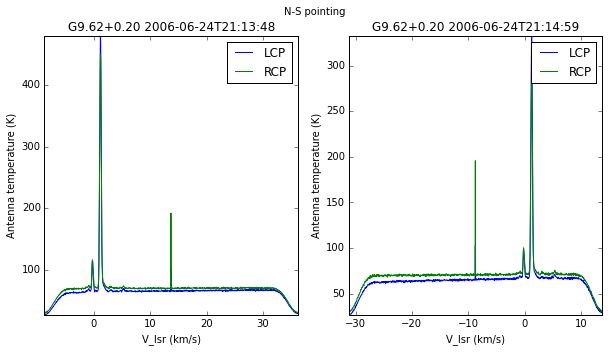

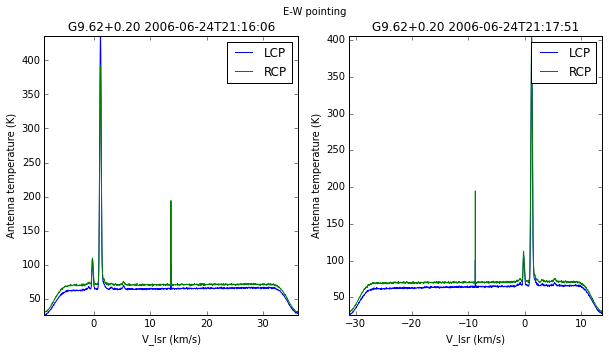

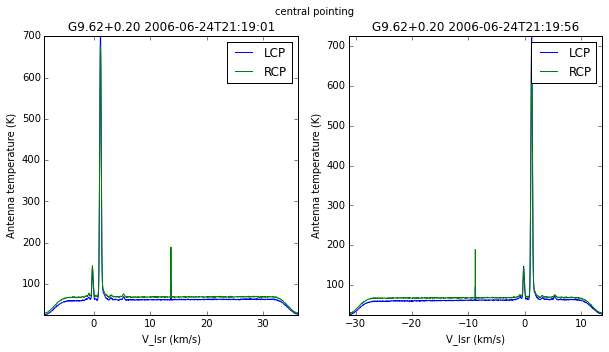

In [41]:
plt.figure(figsize=[10,5])
plt.suptitle('N-S pointing')
plt.subplot(121)
plot_spec(hpn)
plt.subplot(122)
plot_spec(hps)

plt.figure(figsize=[10,5])
plt.suptitle('E-W pointing')
plt.subplot(121)
plot_spec(hpe)
plt.subplot(122)
plot_spec(hpw)

plt.figure(figsize=[10,5])
plt.suptitle('central pointing')
plt.subplot(121)
plot_spec(on1)
plt.subplot(122)
plot_spec(on2)

There is a lot happening in the background to produce these spectra. The conversion of the frequency axis to V_lsr is done online, with Doppler tracking applied. At some telescopes, and possibly the AVN system, the observations may be done without Doppler tracking (topocentric reference frame) and will need to be corrected during reductions.  

Note the spike in the centre of the band.  This is an artefact of the corellating spectrometer and can be ignored. It will be taken care of in subsequent processing when we correct the bandpass during frequency-switching.

Now we subtract the pairs (refer to notebook number 3 for details on frequency-switching bandpass corrections).

In [42]:
def freq_switch(spec1, spec2):
    """
    Correct for bandpass response using frequency-switching and
    return spectra over common velocity range.
    Inputs: 
    spec1 : first observation of frequency-switched pair
    spec2 : second observation of frequency-switched pair
    Returns:
    new_spec1: bandpass-corrected frequency range
    new_spec2: bandpass-corrected frequency range
    
    """
    #subtract reference spectrum from signal
    lcp1 = spec1['LCP'] - spec2['LCP']
    lcp2 = spec2['LCP'] - spec1['LCP']
    rcp1 = spec1['RCP'] - spec2['RCP']
    rcp2 = spec2['RCP'] - spec1['RCP']
    
    #find the indices of the common velocity channels for each spectrum
    spec1_common = np.nonzero(np.in1d(spec1['Vlsr'], spec2['Vlsr']))
    spec2_common = np.nonzero(np.in1d(spec2['Vlsr'], spec1['Vlsr']))
    
    #make a copy of the input spectra to preserve the header information
    new_spec1 = spec1.copy()
    new_spec2 = spec2.copy()
    
    #insert the new spectra into the copies
    new_spec1['Vlsr'] = spec1['Vlsr'][spec1_common]
    new_spec1['LCP'] = lcp1[spec1_common]
    new_spec1['RCP'] = rcp1[spec1_common]
    
    new_spec2['Vlsr'] = spec2['Vlsr'][spec2_common]
    new_spec2['LCP'] = lcp2[spec2_common]
    new_spec2['RCP'] = rcp2[spec2_common]

    
    return new_spec1, new_spec2

In [43]:
hpn_corr, hps_corr = freq_switch(hpn, hps)
hpe_corr, hpw_corr = freq_switch(hpe, hpw)
on1_corr, on2_corr = freq_switch(on1,on2)

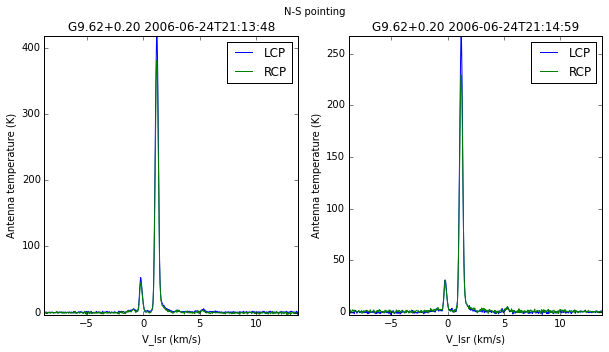

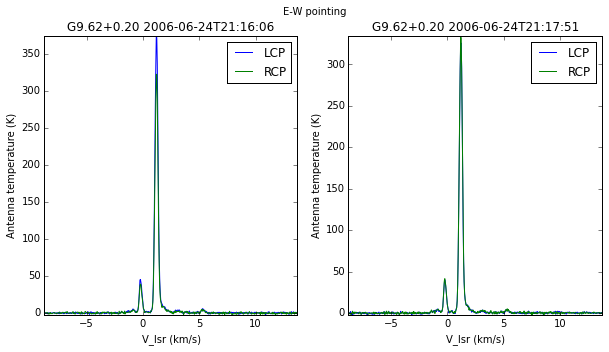

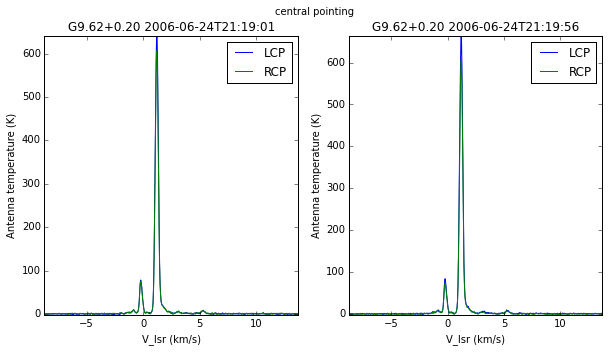

In [44]:
plt.figure(figsize=[10,5])
plt.suptitle('N-S pointing')
plt.subplot(121)
plot_spec(hpn_corr)
plt.subplot(122)
plot_spec(hps_corr)

plt.figure(figsize=[10,5])
plt.suptitle('E-W pointing')
plt.subplot(121)
plot_spec(hpe_corr)
plt.subplot(122)
plot_spec(hpw_corr)

plt.figure(figsize=[10,5])
plt.suptitle('central pointing')
plt.subplot(121)
plot_spec(on1_corr)
plt.subplot(122)
plot_spec(on2_corr)

In [45]:
def flatten_baseline(Vlsr, Amp, line_range):
    """
    Remove residual baseline variation after frequency- or position-switching.
    Inputs:
        Vlsr: array of velocity values
        Amp: array of intensity as a function of velocity
        line_range: two-element array with start and end velocity of line emission.
        
    The line emmission range is masked before a fit is performed on the baseline.
    
    Returns: Corrected amplitude
    
    To do:  generalise mask to use multiple line ranges.
    """
    line_chans = np.where(np.logical_and(Vlsr>=line_range[0], Vlsr<=line_range[1]))
    mask = np.zeros(len(Amp))
    mask[line_chans] = 1
    vel_mask = np.ma.array(Vlsr, mask = mask)
    amp_mask = np.ma.array(Amp, mask = mask)

    #In general, we have found that a third-order polynomial is sufficient to fit the spectral baseline
    p = np.poly1d(np.ma.polyfit(vel_mask, amp_mask,  3))
    basefit = p(Vlsr)

    plt.figure(figsize = [15,5])
    plt.plot(Vlsr, Amp)
    plt.plot(vel_mask, amp_mask)
    plt.plot(Vlsr, basefit)
    lim = plt.axis('tight')
    plt.ylim(-2,5)
    plt.ylabel('Amplitude')
    plt.xlabel('Vlsr')

    Amp = Amp - basefit
    
    return Amp

Inspect the spectra to determine the velocity range of the spectral features so that we can flatten the baseline.

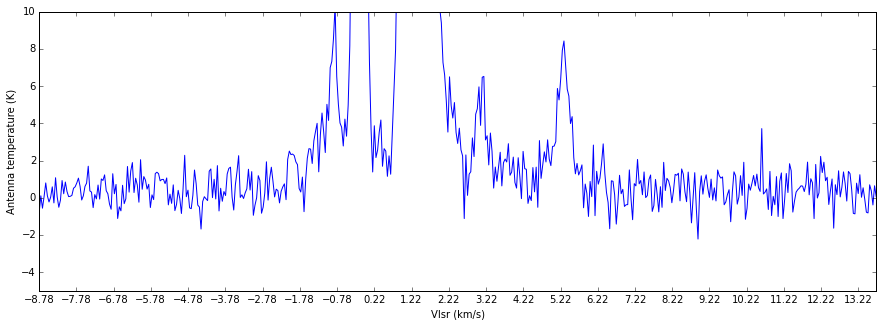

In [46]:
plt.figure(figsize = [15,5])
ax = plt.subplot(111)
plt.plot(on1_corr['Vlsr'], on1_corr['RCP'])
plt.axis('tight')
plt.ylim(-5, 10)
plt.xlabel('Vlsr (km/s)')
plt.ylabel('Antenna temperature (K)')
start, end = ax.get_xlim()
tick_interval = 1
ticks = ax.xaxis.set_ticks(np.arange(start, end, tick_interval))  # makes it easier to get velocity ranges

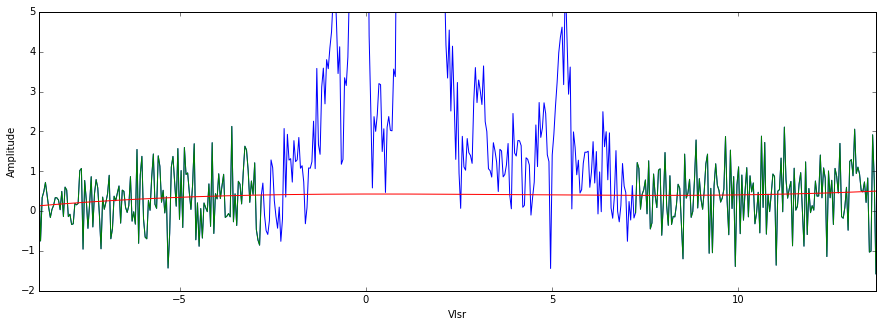

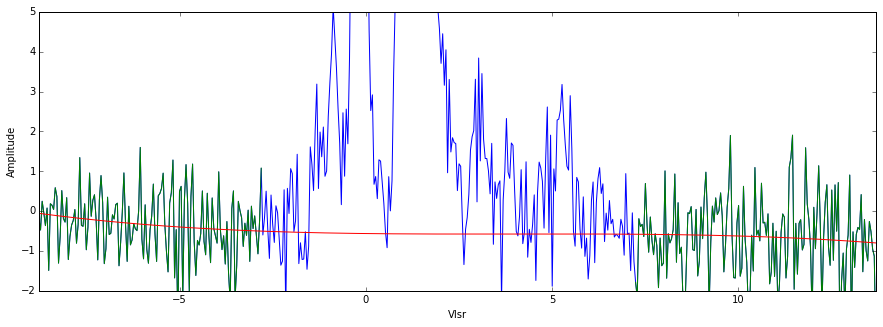

In [47]:
line_range = [-2.78, 7.22]
hpn_corr['LCP'] = flatten_baseline(hpn_corr['Vlsr'], hpn_corr['LCP'], line_range)
hpn_corr['RCP'] = flatten_baseline(hpn_corr['Vlsr'], hpn_corr['RCP'], line_range)

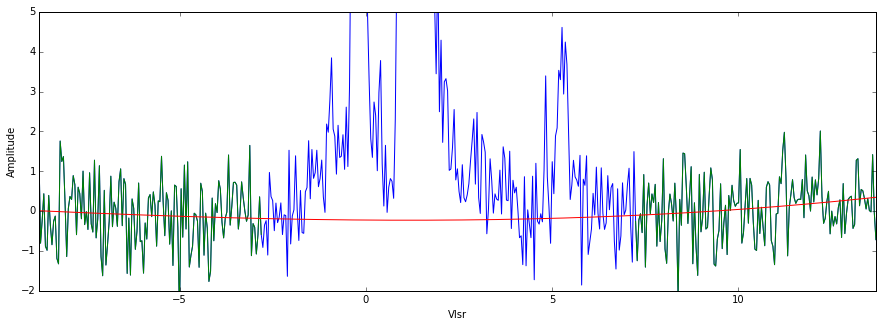

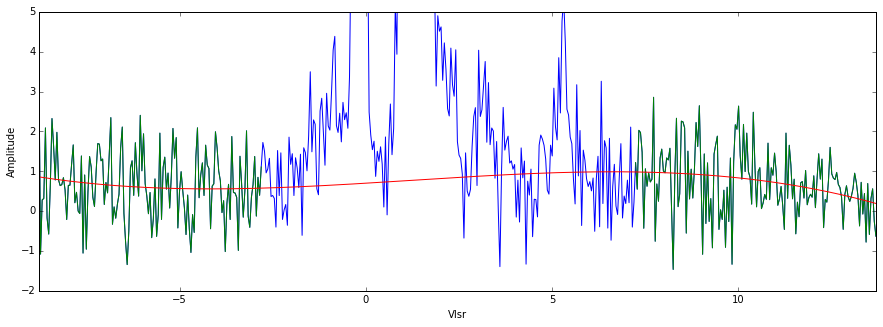

In [48]:
hps_corr['LCP'] = flatten_baseline(hps_corr['Vlsr'], hps_corr['LCP'], line_range)
hps_corr['RCP'] = flatten_baseline(hps_corr['Vlsr'], hps_corr['RCP'], line_range)

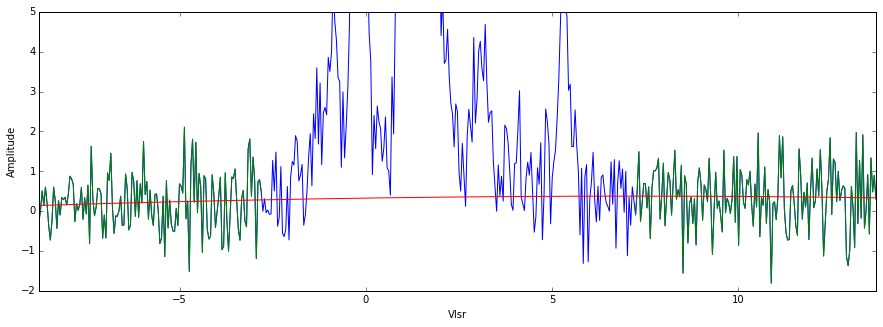

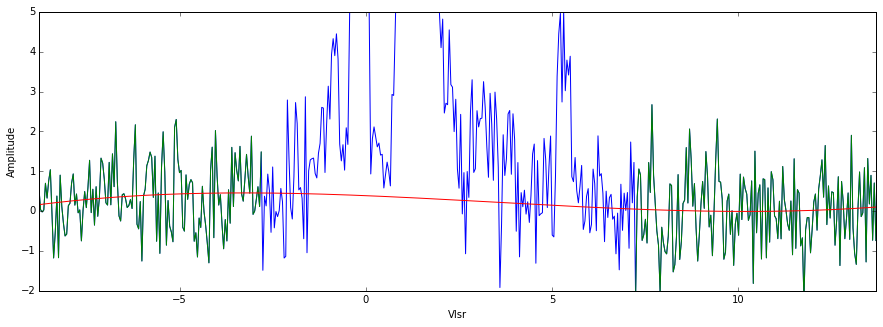

In [49]:
hpe_corr['LCP'] = flatten_baseline(hpe_corr['Vlsr'], hpe_corr['LCP'], line_range)
hpe_corr['RCP'] = flatten_baseline(hpe_corr['Vlsr'], hpe_corr['RCP'], line_range)

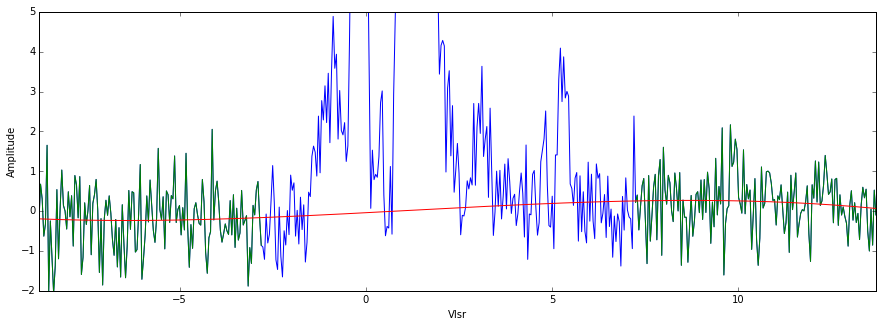

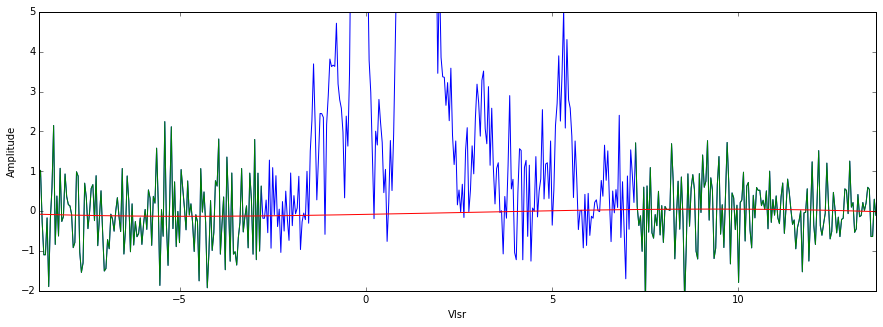

In [50]:
hpw_corr['LCP'] = flatten_baseline(hpw_corr['Vlsr'], hpw_corr['LCP'], line_range)
hpw_corr['RCP'] = flatten_baseline(hpw_corr['Vlsr'], hpw_corr['RCP'], line_range)

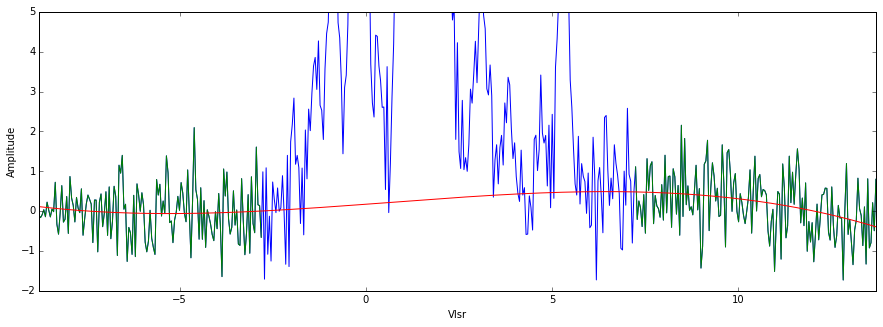

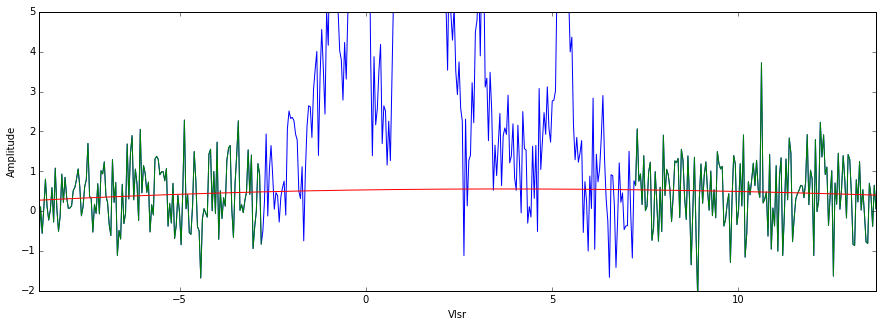

In [51]:
on1_corr['LCP'] = flatten_baseline(on1_corr['Vlsr'], on1_corr['LCP'], line_range)
on1_corr['RCP'] = flatten_baseline(on1_corr['Vlsr'], on1_corr['RCP'], line_range)

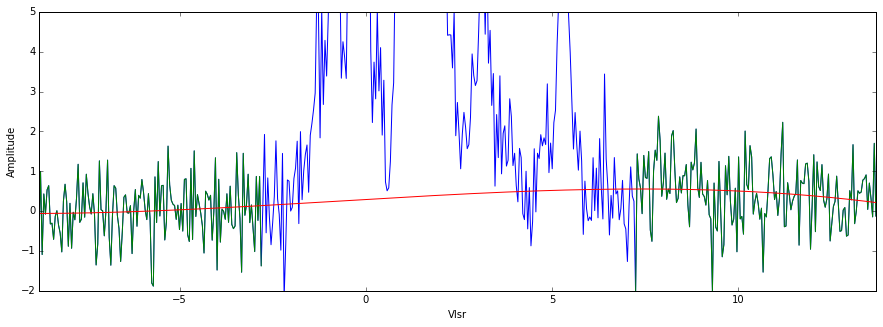

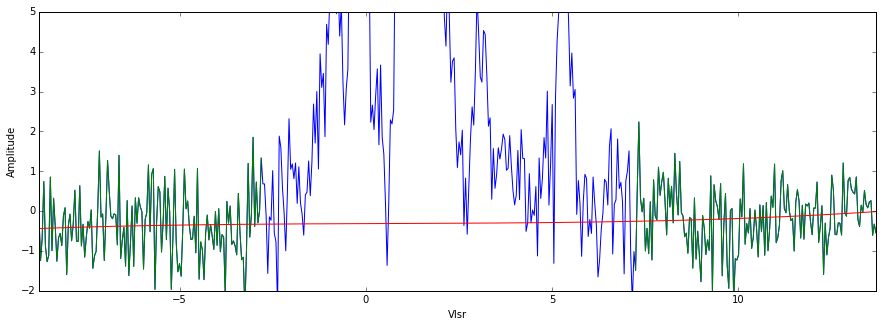

In [52]:
on2_corr['LCP'] = flatten_baseline(on2_corr['Vlsr'], on2_corr['LCP'], line_range)
on2_corr['RCP'] = flatten_baseline(on2_corr['Vlsr'], on2_corr['RCP'], line_range)

There are two corrected spectra for the central pointing.  We can average these two in time to improve the signal-to-noise ratio.

In [53]:
def ave_spec(spec1, spec2):
    """
    Average spectra in time using a weighting according to integration time.
    Return a new spectrum.
    """
    t_int = [spec1['t_int'], spec2['t_int']]
    #find weighted of the corrected spectra
    ave_lcp = np.average(np.vstack([spec1['LCP'], spec2['LCP']]), axis=0, weights=t_int)
    ave_rcp = np.average(np.vstack([spec1['RCP'], spec2['RCP']]), axis=0, weights=t_int)
    
    #find mid point between times of observation
    time1 = Time(spec1['date'], scale='utc', format='isot')
    time2 = Time(spec2['date'], scale='utc', format='isot')
    dt = (time2 - time1)/2
    mid_time = time1 +dt
    
    #construct new spectrum
    ave_spec = {'object' : spec1['object'],
                'longitude' : spec1['longitude'],
                'latitude' : spec1['latitude'],
                'equinox' : spec1['equinox'],
                't_int' : np.sum(t_int),
                'HPBW' : spec1['HPBW'],
                'date' : mid_time.iso,    
                'Vlsr' : spec1['Vlsr'],
                'LCP' : ave_lcp,
                'RCP' : ave_rcp,
                'Tsys_lcp' : np.mean([spec1['Tsys_lcp'], spec2['Tsys_lcp']]),
                'DTsys_lcp' : np.mean([spec1['DTsys_lcp'], spec2['DTsys_lcp']]) ,
                'Tsys_rcp' : np.mean([spec1['Tsys_rcp'], spec2['Tsys_rcp']]),
                'DTsys_rcp': np.mean([spec1['DTsys_rcp'], spec2['DTsys_rcp']])}
    return ave_spec

In [54]:
centre_point = ave_spec(on1_corr, on2_corr)

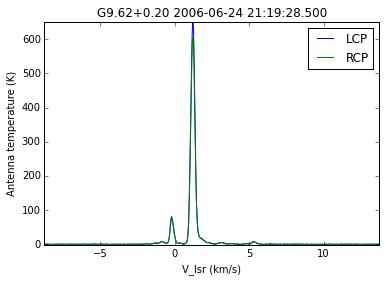

In [55]:
plot_spec(centre_point)

The pointing offset should be the same for both polarisations.  To improve the signal-to-noise ratio, we can also average the polarisations together.  Note that when calculating the unpolarised  ** *flux density* ** of the source we add the two polarisations, after correcting for the gain.

In [56]:
def ave_pols(spec):
    """
    Average RCP and LCP pointing spectra and save in new data column.
    Return enhanced spectrum object.
    """
    spec['ave_pol'] = np.mean(np.vstack([spec['RCP'],spec['LCP']]), axis=0)
    return spec
    

In [57]:
hpn_corr = ave_pols(hpn_corr)
hps_corr = ave_pols(hps_corr)
hpe_corr = ave_pols(hpe_corr)
hpw_corr = ave_pols(hpw_corr)
centre_point = ave_pols(centre_point)

Plot everything again

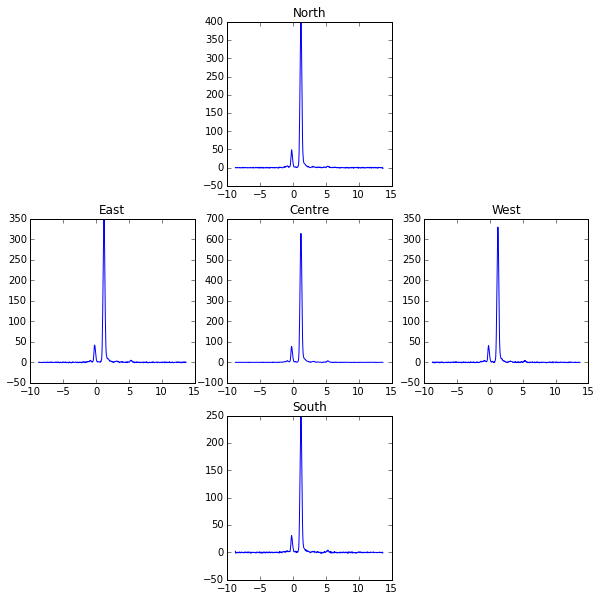

In [58]:
plt.figure(figsize=[10,10])

plt.subplot(332)
plt.title('North')
plt.plot(hpn_corr['Vlsr'], hpn_corr['ave_pol'])

plt.subplot(334)
plt.title('East')
plt.plot(hpe_corr['Vlsr'], hpe_corr['ave_pol'])

plt.subplot(335)
plt.title('Centre')
plt.plot(centre_point['Vlsr'], centre_point['ave_pol'])

plt.subplot(336)
plt.title('West')
plt.plot(hpw_corr['Vlsr'], hpw_corr['ave_pol'])

plt.subplot(338)
plt.title('South')
plt.plot(hps_corr['Vlsr'], hps_corr['ave_pol'])

Next we select the strongest maser peak, and find its amplitude in each pointing.

In [59]:
# measure amplitude of peak for each pointing
def fit_max(spec, peak_vel, half_width):
    """
    Inputs:
        spec : a spectrum with columns 'Vlsr' and 'Amp'
        peak_vel : velocity at which to fit the maximum amplitdue
        half_width : How many channels to include on either side of the peak velocity.
                     This will depend on the width of the maser peak and 
                     how well a quadratic function fits the top of the peak
                     
    Returns:
        maximum amplitude
    """
    #find channel closest to specified velocity
    vel_chan = np.abs(spec['Vlsr']-peak_vel).argmin()

    #for noisy spectra - ie weak sources, it is better to do a quadratic fit over a few channels around the peak.
    chans = range(vel_chan-half_width, vel_chan+half_width)

    plt.plot(spec['Vlsr'][chans], spec['ave_pol'][chans], 'ko')
    p = np.poly1d(np.polyfit(spec['Vlsr'][chans], spec['ave_pol'][chans],  3))
    fit_x = np.linspace(spec['Vlsr'][min(chans)], spec['Vlsr'][max(chans)], 50)
    fit = p(fit_x)
    plt.plot(fit_x, fit, 'r')
    return  fit.max()

You can find the peak velocity by inspection of the central observation, or just find the location of the maximum amplitude in the averaged spectrum.

In [60]:
peak_vel = centre_point['Vlsr'][np.argmax(centre_point['ave_pol'])]
print('Peak velocity is at %.2f km/s'%peak_vel)
half_width = 5   # number of channels on either side of the peak to use for peak fit

Peak velocity is at 1.18 km/s


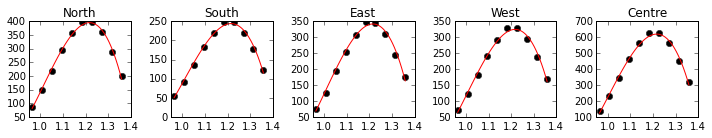

In [61]:
# Find the max power for each pointing measurement
fig = plt.figure(figsize=[10,2])
plt.subplot(151)
plt.title('North')
north = fit_max(hpn_corr, peak_vel, half_width)
plt.subplot(152)
plt.title('South')
south = fit_max(hps_corr, peak_vel, half_width)
plt.subplot(153)
plt.title('East')
east = fit_max(hpe_corr, peak_vel, half_width)
plt.subplot(154)
plt.title('West')
west = fit_max(hpw_corr, peak_vel, half_width)
plt.subplot(155)
plt.title('Centre')
cen = fit_max(centre_point, peak_vel, half_width)
fig.tight_layout()

Now for the pointing correction, we need information on the beam.  We can calculate it ourselves, but it is stored in one of the headers, and our calculation will be consistent with the offsets used by the control system.

In [62]:
# calculate pointing correction
from scipy.optimize import curve_fit
def gauss(x, *p):
    A, mu = p
    sigma = hpbw/(2*np.sqrt(2*np.log(2)))  #a bit messy but not sure how to pass a constant through the curve fitting
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


def pointcor(north, south, east, west, cen, hpbw):
    """
    Given the power measured at the half-power points of the beam,
    calculate the correction factor for the source amplitude.
    The current implementation calculates the North-South and E-W 
    beams independently using a 1-D gaussian.
    We keep the width of the beam fixed during the fit.
    
    Inputs:
        north: Peak power measured at half-power point North 
        south: Peak power measured at half-power point South
        east: Peak power measured at half-power point East 
        west: Peak power measured at half-power point West
        cen: Peak power measured on source
        hpbw: half-power beam-width of the telescope
        
    Returns:
        Corrective factor for peak amplitude
    
    To do: 
        2D fit
        Uncertainty using T_sys
    """
    hhpbw = hpbw/2
    x = [-hhpbw, 0, +hhpbw]             
    p0 = [cen, 0.001]
    
    ns = [south, cen, north]
    ns_coeff, ns_var_matrix = curve_fit(gauss, x, ns, p0)
    smooth = np.linspace(-4*hhpbw, 4*hhpbw, 100)
    ns_fits = gauss(smooth, *ns_coeff)

    ew = [west, cen, east]
    ew_coeff, ew_var_matrix = curve_fit(gauss, x, ew, p0)
    ew_fits = gauss(smooth, *ew_coeff)

    fig = plt.figure(figsize=[11,5])
    ax = plt.subplot(121)
    plt.plot(x, ns, 'bo')
    plt.plot(smooth, ns_fits, color='b')
    plt.title('North-South pointing offset '+ str(round(ns_coeff[1],3)) +' deg')
    #plt.axis('tight')
    plt.vlines(ns_coeff[1]+hhpbw, 0, cen, linestyle='dotted')
    plt.vlines(ns_coeff[1], 0, cen, linestyle='dotted')
    plt.vlines(ns_coeff[1]-hhpbw, 0, cen, linestyle='dotted')
    ax = plt.subplot(122)
    plt.plot(x, ew, 'ro')
    plt.plot(smooth, ew_fits, color='r')
    #plt.axis('tight')
    plt.vlines(ew_coeff[1]+hhpbw, 0, cen, linestyle='dotted')
    plt.vlines(ew_coeff[1], 0, cen, linestyle='dotted')
    plt.vlines(ew_coeff[1]-hhpbw, 0, cen, linestyle='dotted')
    plt.title('East-West pointing offset '+str(round(ew_coeff[1],3)) +' deg')
    
    return np.exp(np.log(2) * (ns_coeff[1]**2 + ew_coeff[1]**2) / hhpbw**2)
     

In [63]:
hpbw = centre_point['HPBW']

Pointing correction factor 1.02154805551


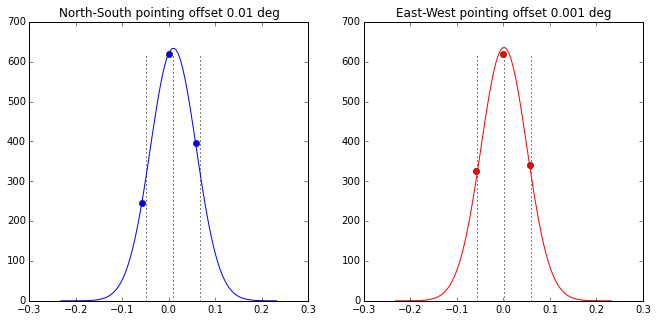

In [64]:
pc = pointcor(north, south, east, west, cen, hpbw)
print 'Pointing correction factor', pc